In [0]:
# coding: utf-8
# Define load dataset functions
# 定义加载数据集函数

try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = "./datasets"
if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)
    
save_file = dataset_dir + "/mnist.pkl"


train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
        _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

In [0]:
# coding: utf-8
# Define common functions and classes.
# 定义常用的函数和类

import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))   

# 交叉商
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # If label is one-hot-vector,convert to the correct label.
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


# 均方误差
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

    
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad    


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

    
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    

class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # Derivatives of weights and parameters.
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape) 
        return dx

       
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax output
        self.t = None # label

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # label: one-hot-vector
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx    


In [0]:
# coding: utf-8
# Define Network
# 定义网络

import sys, os
sys.path.append(os.pardir) 
import numpy as np
from collections import OrderedDict


class Network:

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1'] = np.zeros(hidden_size_1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2'] = np.zeros(hidden_size_2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size_2, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # Generate layers.
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])        

        self.lastLayer = SoftmaxWithLoss()

    # Predict
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:Input, t: Label
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    # Accuracy     
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # Gradient
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
        return grads

In [4]:
# coding: utf-8
# Training Network
# 训练网络

import sys, os
sys.path.append(os.pardir)

import numpy as np
# from dataset.mnist import load_mnist

# Load Data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = Network(input_size=784, hidden_size_1=50, hidden_size_2=50, output_size=10)

# Hyperparameter
iters_num = 14400   
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []


# Average number of repetitions per epoch
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # Calculating the gradient
    grad = network.gradient(x_batch, t_batch)
    
    # Update parameters
    for key in ('W1', 'b1', 'W2', 'b2','W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    # Record learning process 
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # Calculate the recognition accuracy of each epoch    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('epochs: %s, train_acc: %.4f, test_acc: %.4f,'% (len(train_acc_list), train_acc, test_acc) )

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
epochs: 1, train_acc: 0.1124, test_acc: 0.1135,
epochs: 2, train_acc: 0.7393, test_acc: 0.7480,
epochs: 3, train_acc: 0.8690, test_acc: 0.8730,
epochs: 4, train_acc: 0.9195, test_acc: 0.9189,
epochs: 5, train_acc: 0.9297, test_acc: 0.9241,
epochs: 6, train_acc: 0.9540, test_acc: 0.9505,
epochs: 7, train_acc: 0.9610, test_acc: 0.9568,
epochs: 8, train_acc: 0.9642, test_acc: 0.9544,
epochs: 9, train_acc: 0.9683, test_acc: 0.9599,
epochs: 10, train_acc: 0.9741, test_acc: 0.9668,
epochs: 11, train_acc: 0.9759, test_acc: 0.9670,
epochs: 12, train_acc: 0.9766, test_acc: 0.9643,
epochs: 13, train_acc: 0.9798, test_acc: 0.9668,
epochs: 14, train_acc: 0.9824, test_acc: 0.9693,
epochs: 15, train_acc: 0.9

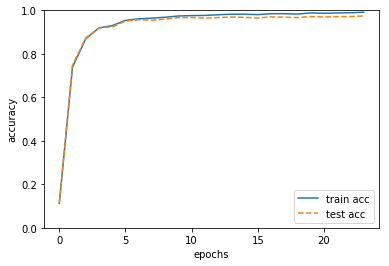

In [5]:
# Draw training and test curve
# 绘制训练和测试曲线

import matplotlib.pyplot as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()